# GHONN pytorch models playground
place for testing the pytorch models

In [1]:
# Import libs

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from src import HONU



## Create test data
Generate random sinus data for testing the HONU, HONN and GHONN models.

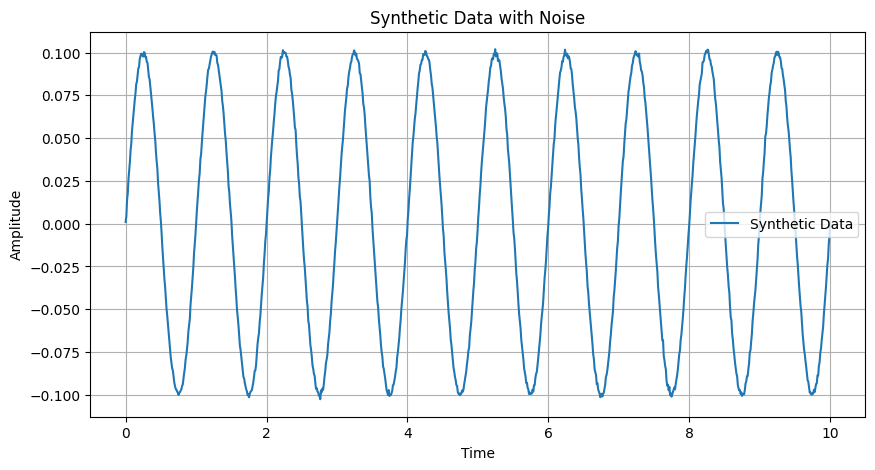

In [2]:
freqs = [1]
amps = [0.1, 0.2, 0.3]
phases = [0, 0.5, 1]
noise_lvl = 0.001
t_max = 10
n_samples = 1000
t = np.linspace(0, t_max, n_samples)
# Generate synthetic data
signals = [amps[i] * np.sin(2 * np.pi * freqs[i] * t + phases[i]) for i in range(len(freqs))]
noise = np.random.normal(0, noise_lvl, t.shape)
data = np.sum(signals, axis=0) + noise
# Plot the synthetic data
plt.figure(figsize=(10, 5))
plt.plot(t, data, label="Synthetic Data")
plt.title("Synthetic Data with Noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [14]:
# Prepare data for the models
N = data.shape[0]
prev_vals = 5
prediction_horizon = 1

X = np.zeros((N - prev_vals - prediction_horizon + 1, prev_vals))
y = np.zeros((N - prev_vals - prediction_horizon + 1, 1))

for i in range(prev_vals, N - prediction_horizon + 1):
    X[i - prev_vals] = data[i - prev_vals:i][::-1]
    y[i - prev_vals] = data[i + prediction_horizon - 1]

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_Train[0] input: {X_train[0]}, y_Train output: {y_train[0]}")
print(f"X_Train[1] input: {X_train[1]}, y_Train output: {y_train[1]}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (796, 5), y_train shape: (796, 1)
X_Train[0] input: [0.6277966  0.58813124 0.56824231 0.52252461 0.5063678 ], y_Train output: [0.65268931]
X_Train[1] input: [0.65268931 0.6277966  0.58813124 0.56824231 0.52252461], y_Train output: [0.67708356]
X_test shape: (199, 5), y_test shape: (199, 1)


In [27]:
# Train the HONU model
order = 3
lr = 0.001
batch_size = 3
epochs = 10
honu = HONU(X.shape[0], order=order)
optimizer = torch.optim.Adam(honu.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

# Convert data to PyTorch tensors and add batch dimension
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Training loop
for epoch in range(epochs):
    permutation = torch.randperm(X_train_tensor.size(0))
    epoch_loss = 0.0
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        input_batch, target_batch = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = honu(input_batch)
        loss = loss_fn(outputs, target_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / (X_train_tensor.size(0) // batch_size)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")


KeyboardInterrupt: 

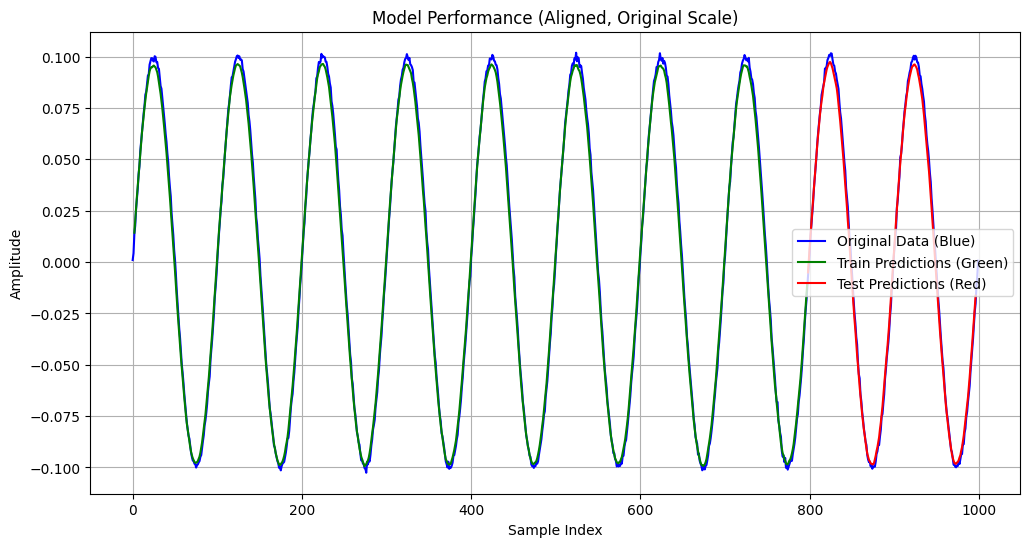

In [26]:
# Predict on training and testing data
train_predictions = honu(X_train_tensor).detach().numpy()
test_predictions = honu(X_test_tensor).detach().numpy()

# Inverse transform predictions and targets to original scale
train_predictions_orig = scaler.inverse_transform(train_predictions)
test_predictions_orig = scaler.inverse_transform(test_predictions)
y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)

# Calculate the correct offset for alignment
offset = prediction_horizon + 1

plt.figure(figsize=(12, 6))
# Plot the full original data
plt.plot(data, label="Original Data (Blue)", color="blue")
# Plot train predictions at the correct positions
plt.plot(
    np.arange(offset, offset + len(train_predictions_orig)),
    train_predictions_orig,
    label="Train Predictions (Green)",
    color="green"
)
# Plot test predictions at the correct positions
plt.plot(
    np.arange(offset + len(train_predictions_orig), offset + len(train_predictions_orig) + len(test_predictions_orig)),
    test_predictions_orig,
    label="Test Predictions (Red)",
    color="red"
)
plt.title("Model Performance (Aligned, Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()